### Step2: cell type clustering using marker genes

25 types based on 77/75 marker genes\
combine all regions R1-R8

In [18]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from collections import Counter
import timeit
# pd.options.mode.chained_assignment = None  # default='warn'

### Step5.1: prepare data for cell typing

#### Load cropped data

In [3]:
##### Load bin1 R1-R8 and add some more stats

bin1_dict = {}
for r in range(1,9):
    print('R =', r)
    filename = 'output_step1/crop_R'+str(r)+'_dict.pkl'
    # load
    with open(filename, 'rb') as f:
        pickle_dict = pickle.load(f)
    bin1 = pickle_dict['bin1']
    bin1_dict['R'+str(r)+'_bin1'] = bin1

print(bin1_dict.keys())
print(bin1_dict['R1_bin1'].head())

bin1_R1 = bin1_dict['R1_bin1'].copy()
bin1_R2 = bin1_dict['R2_bin1'].copy()
bin1_R3 = bin1_dict['R3_bin1'].copy()
bin1_R4 = bin1_dict['R4_bin1'].copy()
bin1_R5 = bin1_dict['R5_bin1'].copy()
bin1_R6 = bin1_dict['R6_bin1'].copy()
bin1_R7 = bin1_dict['R7_bin1'].copy()
bin1_R8 = bin1_dict['R8_bin1'].copy()

# create cell label cross entire E1S3
bin1_R1['cell_E1S3'] = bin1_R1.cell.copy()
# bin1_R2['cell_E1S3'] = bin1_R2.cell.copy() + bin1_R1.cell_E1S3.max() #74777
# bin1_R3['cell_E1S3'] = bin1_R3.cell.copy() + bin1_R2.cell_E1S3.max() #127607
# bin1_R4['cell_E1S3'] = bin1_R4.cell.copy() + bin1_R3.cell_E1S3.max() #234033
# bin1_R5['cell_E1S3'] = bin1_R5.cell.copy() + bin1_R4.cell_E1S3.max() #316767
# bin1_R6['cell_E1S3'] = bin1_R6.cell.copy() + bin1_R5.cell_E1S3.max() #404015
# bin1_R7['cell_E1S3'] = bin1_R7.cell.copy() + bin1_R6.cell_E1S3.max() #483711
# bin1_R8['cell_E1S3'] = bin1_R8.cell.copy() + bin1_R7.cell_E1S3.max() #528038
bin1_R2['cell_E1S3'] = bin1_R2.cell.copy() + 74777
bin1_R3['cell_E1S3'] = bin1_R3.cell.copy() + 127607
bin1_R4['cell_E1S3'] = bin1_R4.cell.copy() + 234033
bin1_R5['cell_E1S3'] = bin1_R5.cell.copy() + 316767
bin1_R6['cell_E1S3'] = bin1_R6.cell.copy() + 404015
bin1_R7['cell_E1S3'] = bin1_R7.cell.copy() + 483711
bin1_R8['cell_E1S3'] = bin1_R8.cell.copy() + 528038

# concatenate bin_R1-binR8
bin1 = pd.concat([bin1_R1, bin1_R2, bin1_R3, bin1_R4, 
                  bin1_R5, bin1_R6, bin1_R7, bin1_R8])
print(bin1.shape) 
print(bin1.head())

# rename cols
bin1 = bin1.rename(columns={'cell': 'cell_r', 'cell_E1S3': 'cell'})
print(bin1.shape) 
print(bin1.head())

R = 1
R = 2
R = 3
R = 4
R = 5
R = 6
R = 7
R = 8
dict_keys(['R1_bin1', 'R2_bin1', 'R3_bin1', 'R4_bin1', 'R5_bin1', 'R6_bin1', 'R7_bin1', 'R8_bin1'])
    geneID      x      y  umi    xr    yr   cell  centerX_r  centerY_r  \
12    Cr1l  26717  13204    1   717  3704  12014        712       3700   
32    Cr1l  28282  14437    1  2282  4937  35736       2291       4944   
140   Cr1l  29228  15955    1  3228  6455  49512       3234       6442   
454   Cr1l  28116  13051    1  2116  3551  33156       2114       3556   
459   Cr1l  26934  12445    1   934  2945  15337        946       2941   

     centerX  centerY  
12     26712    13200  
32     28291    14444  
140    29234    15942  
454    28114    13056  
459    26946    12441  
(64749821, 12)
    geneID      x      y  umi    xr    yr   cell  centerX_r  centerY_r  \
12    Cr1l  26717  13204    1   717  3704  12014        712       3700   
32    Cr1l  28282  14437    1  2282  4937  35736       2291       4944   
140   Cr1l  29228  15955  

In [6]:
##### add cols

### compute x/yrange
min_ = bin1.groupby(['cell']).min().reset_index()
print(min_.head())
max_ = bin1.groupby(['cell']).max().reset_index()
print(max_.head())

# check if match
print(sum(max_.cell != min_.cell)) 
# expect =0

# compute range
xrange_ = max_.x - min_.x 
yrange_ = max_.y - min_.y 
cell_range_ = max_.cell 
print(len(xrange_), len(yrange_), len(cell_range_))

# append xrange_ yrange_ to bin1
data = bin1.cell.tolist()
keys = cell_range_.tolist()
vals = np.array((xrange_.tolist(), yrange_.tolist())).T
memo = defaultdict(lambda: (0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))

print(len(res0), len(data), len(keys), len(vals))

bin1['sc_xrange'] = np.array(res0)
bin1['sc_yrange'] = np.array(res1)
print(bin1.head())

### append x/y min/max to bin1
data = bin1.cell.tolist()
keys = min_.cell.tolist()
vals = np.array((min_.x.tolist(), max_.x.tolist(), min_.y.tolist(), max_.y.tolist())).T
memo = defaultdict(lambda: (0, 0, 0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))
res2 = list(map(lambda x: memo[x][2], data))
res3 = list(map(lambda x: memo[x][3], data))

print(len(res0), len(data), len(keys), len(vals)) 

bin1['sc_xmin'] = np.array(res0)
bin1['sc_xmax'] = np.array(res1)
bin1['sc_ymin'] = np.array(res2)
bin1['sc_ymax'] = np.array(res3)
print(bin1.head())

### sc total counts
scagt = bin1.groupby(['cell']).sum().reset_index()
print(scagt.head())
# print(scagt.umi.quantile([0.1,0.5,0.9])) # comment out to save time

# append
data = bin1['cell'].tolist()
keys = scagt.cell.tolist()
vals = scagt.umi.tolist()
memo = defaultdict(int)
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')
res = list(map(lambda x: memo[x], data))  

print(len(res), len(data), len(keys), len(vals)) 

bin1['sc_total'] = np.array(res)
print(bin1.head()) 

### sc number of genes
sc_ngenes = bin1.groupby('cell')['geneID'].nunique() 
# print(sc_ngenes.quantile([0.1,0.5,0.9])) # comment out to save time
print(sc_ngenes.head())

# append
data = bin1['cell'].tolist()
keys = sc_ngenes.index.tolist()
vals = sc_ngenes.tolist()
memo = defaultdict(int)
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')
res = list(map(lambda x: memo[x], data))  

print(len(res), len(data), len(keys), len(vals))

bin1['sc_ngene'] = np.array(res)
print(bin1.head()) 

   cell         geneID      x      y  umi  xr    yr  cell_r  centerX_r  \
0   308  0610012G03Rik  26007  10145    1   7   645     308         19   
1   312  2600014E21Rik  26007  11077    1   7  1577     312         15   
2   330  0610009B22Rik  26008  10931    1   8  1431     330         18   
3   331  1700007G11Rik  26008  11119    1   8  1619     331         23   
4   332  1700007G11Rik  26012  11788    1  12  2288     332         16   

   centerY_r  centerX  centerY  
0        664    26019    10164  
1       1585    26015    11085  
2       1439    26018    10939  
3       1633    26023    11133  
4       2299    26016    11799  
   cell  geneID      x      y  umi  xr    yr  cell_r  centerX_r  centerY_r  \
0   308  mt-Nd6  26036  10175    5  36   675     308         19        664   
1   312  mt-Nd6  26022  11092    4  22  1592     312         15       1585   
2   330  mt-Nd1  26029  10947    4  29  1447     330         18       1439   
3   331  mt-Nd6  26033  11141    4  33  1641 

/tmp/ipykernel_35550/590344275.py:105: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scagt = bin1.groupby(['cell']).sum().reset_index()


   cell         x         y   umi     xr       yr  cell_r  centerX_r  \
0   308  28807383  11245718  1572  25383   729218  340956      21033   
1   312   9729769   4145575   529   5769   592575  116688       5610   
2   330  12749391   5360124   713   9391   705124  161700       8820   
3   331  15717895   6723682   882  13895   985682  199924      13892   
4   332  15766746   7150062   867  10746  1393062  201192       9696   

   centerY_r   centerX   centerY  sc_xrange  sc_yrange   sc_xmin   sc_xmax  \
0     735048  28803033  11251548      32103      33210  28789749  28821852   
1     592790   9729610   4145790       5610       5610   9726618   9732228   
2     705110  12748820   5360110      10290       7840  12743920  12754210   
3     986332  15717892   6724332      15100      13288  15708832  15723932   
4    1393194  15765696   7150194       9090      12726  15763272  15772362   

    sc_ymin   sc_ymax  
0  11230515  11263725  
1   4142798   4148408  
2   5356190   5364030  
3 

In [9]:
# number of cells
print(f'#cells = {bin1.cell.nunique()}')

#cells = 99726


In [10]:
# change col name
bin1 = bin1.rename(columns={'geneID': 'gene'})

### Step 5.2: naive cell typing

for 77 (actually 75 unique) marker genes compute sc total counts with `bin1`\
use `sc_type25_norm_mat` for finding cell type with argmax\
for each cell (col), find the largest val (row idx) as the cell type

In [13]:
##### cell type markers for the whole E16.5 embryo 

# from `Markers_used_for_annotations_in_the_MOSTA.xlsx`
marker77List = [
    'Myl2', 'Myh7', 'Tnnt2', # Cardiomyocyte
    'Col2a1', 'Col9a1', 'Col11a1', 'Runx2', # Chondrocyte
    'Ttr','Enpp2', 'Igfbp2', # Choroid plexus
    'Tfap2b', 'Lhx9', 'Zic1', # Dorsal midbrain neuron
    'Nefl', 'Nefm', 'Sncg', # Ganglion
    'Pecam1', 'Kdr','Ptprm', # Endothelial cell
    'Krt4', 'Krtdap', 'Krt10', # Keratinocyte
    'Krt19', 'Epcam', 'Krt8', 'Krt5', 'Adh1', 'Foxp2', # Epithelial cell
    'Hba-a2', 'Hba-a1', 'Hbb-bs', # Erythrocyte
    'Trps1', 'Pax3', 'Wnt5a', # Facial fibroblast
    'Col1a2', 'Col3a1', 'Dcn', # Fibroblast
    'Neurod6', 'Tbr1', 'Neurod2', # Forebrain neuron
    'Fabp7', 'Sox2', 'Pou3f3', # Forebrain radial glia
    'Afp', 'Alb', # Hepatocyte
    'S100a8', 'S100a9', # Immune cell
    'Mecom', 'Gas2', 'Ebf1', # Limb fibroblast
    'Mrc1', 'C1qc', 'Csf1r', # Macrophage
    'Ptgds', 'Trpm3', 'Ranbp3l', # Meninges cell
    'Rtn1', 'Nnat', 'Stmn2', # Mid-/hindbrain and spinal cord neuron
    'Acta1', 'Myl1', 'Myh3', # Myoblast
    'Gstm1', 'Ebf2', 'Fstl5', # Olfactory epithelial cell
    'Fabp7', 'Sox2', 'Slc1a3', # Radial glia
    'Acta2', 'Myh11', 'Tagln', # Smooth muscle cell
    'Npy', 'Cck', 'Lingo2', # Spinal cord neuron
    'Tcf712', 'Ntng1', 'Tenm2'] # Diencephalon neuron
print(len(marker77List)) # 77

# cell type specific list
marker77List2 = [
    ['Myl2', 'Myh7', 'Tnnt2'], #1 Cardiomyocyte
    ['Col2a1', 'Col9a1', 'Col11a1', 'Runx2'], #2 Chondrocyte
    ['Ttr','Enpp2', 'Igfbp2'], #3 Choroid plexus
    ['Tfap2b', 'Lhx9', 'Zic1'], #4 Dorsal midbrain neuron
    ['Nefl', 'Nefm', 'Sncg'], #5 Ganglion
    ['Pecam1', 'Kdr','Ptprm'], #6 Endothelial cell
    ['Krt4', 'Krtdap', 'Krt10'], #7 Keratinocyte
    ['Krt19', 'Epcam', 'Krt8', 'Krt5', 'Adh1', 'Foxp2'], #8 Epithelial cell
    ['Hba-a2', 'Hba-a1', 'Hbb-bs'], #9 Erythrocyte
    ['Trps1', 'Pax3', 'Wnt5a'], #10 Facial fibroblast
    ['Col1a2', 'Col3a1', 'Dcn'], #11 Fibroblast
    ['Neurod6', 'Tbr1', 'Neurod2'], #12 Forebrain neuron
    ['Fabp7', 'Sox2', 'Pou3f3'], #13 Forebrain radial glia
    ['Afp', 'Alb'], #14 Hepatocyte
    ['S100a8', 'S100a9'], #15 Immune cell
    ['Mecom', 'Gas2', 'Ebf1'], #16 Limb fibroblast
    ['Mrc1', 'C1qc', 'Csf1r'], #17 Macrophage
    ['Ptgds', 'Trpm3', 'Ranbp3l'], #18 Meninges cell
    ['Rtn1', 'Nnat', 'Stmn2'], #19 Mid-/hindbrain and spinal cord neuron
    ['Acta1', 'Myl1', 'Myh3'], #20 Myoblast
    ['Gstm1', 'Ebf2', 'Fstl5'], #21 Olfactory epithelial cell
    ['Fabp7', 'Sox2', 'Slc1a3'], #22 Radial glia
    ['Acta2', 'Myh11', 'Tagln'], #23 Smooth muscle cell
    ['Npy', 'Cck', 'Lingo2'], #24 Spinal cord neuron
    ['Tcf712', 'Ntng1', 'Tenm2']] #25 Diencephalon neuron
print(len(marker77List2)) # 25 cell types


# keep unique 75 gene 
marker75List = np.unique(np.array(marker77List)).tolist() 

# keep 75 genes
filter1 = bin1.gene.isin(marker75List)
bin1_marker75 = bin1[filter1]

# group by cell for fast computing
groupbycell_ = bin1_marker75.groupby('cell')
geneUnique = marker75List
cellUnique = bin1_marker75.cell.unique().tolist() 

# dict for finding idx
keys = geneUnique
vals = np.arange(len(geneUnique)).tolist()
memo = {}
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

### sc_mat
# gene by cell mat
# geneUnique by cellUnique
sc_mat = np.zeros((len(geneUnique), len(cellUnique)), dtype=int)
print(sc_mat.shape) # (75, 589241)

start = timeit.default_timer()

for i, c in enumerate(cellUnique):
    c_df = groupbycell_.get_group(c)
    c_g_df = c_df.groupby(['gene']).sum().reset_index()
    data = c_g_df.gene.tolist() 
    idx = list(map(lambda x: memo[x], data))
    sc_mat[idx,i] = c_g_df.umi.tolist()

stop = timeit.default_timer()
print('Time: ', stop - start) 

print(sc_mat.shape) 
print(np.sum(sc_mat)) 

### normalize sc_mat -> `sc_norm_mat`
# norm by sc_umi
data = cellUnique
keys = scagt.cell.tolist()
vals = scagt.umi.tolist()
memo = {}
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')
res = list(map(lambda x: memo[x], data))  

print(len(res), len(data), len(keys), len(vals)) 

# print(np.quantile(res, [0.1,0.5,0.9])) # comment out to save time
# print(np.amax(res)) # comment out to save time

sc_norm_mat = np.zeros((len(geneUnique), len(cellUnique)))
print(sc_norm_mat.shape) 

for r in range(len(geneUnique)):
    sc_norm_mat[r,:] = 10000 * sc_mat[r,:].copy()/np.array(res)   
    
### compute the counts of 25 sets of genes
sc_type25_mat = np.zeros((len(marker77List2), len(cellUnique)))
print(sc_type25_mat.shape)

for t in range(len(marker77List2)):
    list_ = marker77List2[t]
    
    idx_ = []
    for g in list_:
        idx_.append(geneUnique.index(g))
    
    t_mat_ = sc_norm_mat[idx_,:]
    sc_type25_mat[t,:] = np.sum(t_mat_, axis=0)
print(sc_type25_mat.shape)
# (25, 589241) -- revious number of cells
# (25, 99684) -- current number of cells

77
25
(75, 99684)
Time:  185.65546751767397
(75, 99684)
2590557
99684 99684 99726 99726
(75, 99684)
(25, 99684)
(25, 99684)


(25, 99684)


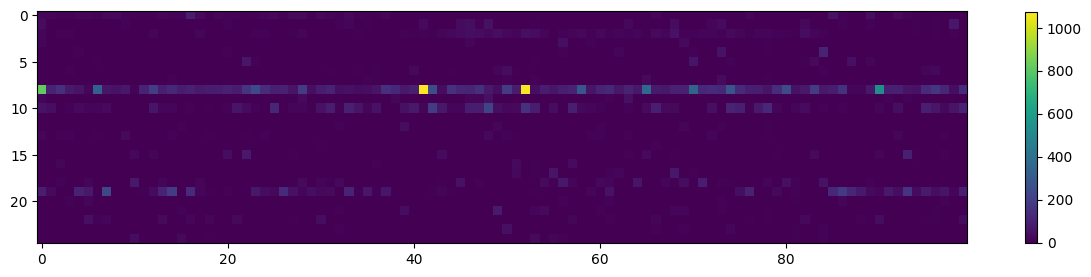

In [15]:
##### plot to check sc_type25_mat
print(sc_type25_mat.shape) 

fig, ax = plt.subplots(1,1,figsize=(15, 5))
im = plt.imshow(sc_type25_mat[:,:100])
plt.colorbar(im, ax=ax, shrink=0.6)

25 99684
(25, 99684)


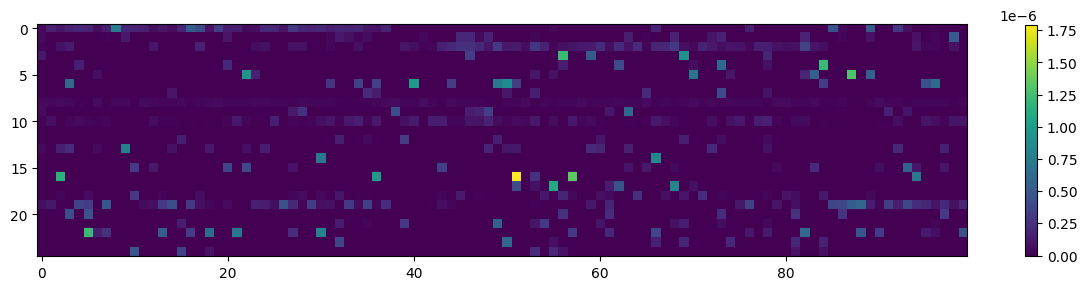

In [16]:
##### norm sc_type25_mat both by row and by col 
# then use sc_type25_norm_mat for finding cell type!
row_sum_ = np.sum(sc_type25_mat, axis=1) 
col_sum_ = np.sum(sc_type25_mat, axis=0) 
print(len(row_sum_), len(col_sum_))
# 25 526509

sc_type25_mat_r = sc_type25_mat / col_sum_
sc_type25_norm_mat = (sc_type25_mat_r.T / row_sum_).T

# plot to check sc_type25_norm_mat
print(sc_type25_norm_mat.shape) 
# (25, 526509)

fig, ax = plt.subplots(1,1,figsize=(15, 5))
im = plt.imshow(sc_type25_norm_mat[:,:100])
plt.colorbar(im, ax=ax, shrink=0.6)

In [17]:
##### use sc_type25_norm_mat for finding cell type
# for each cell (col), find the largest val (row idx) as the cell type
celltype = np.argmax(sc_type25_norm_mat, axis=0)
print(len(celltype))
print(len(np.unique(celltype))) 

print(Counter(celltype))

99684
25
Counter({19: 5988, 10: 5364, 7: 5159, 15: 4921, 9: 4768, 22: 4657, 5: 4562, 13: 4524, 6: 4500, 18: 4399, 8: 4341, 4: 4331, 20: 4317, 1: 4289, 12: 4168, 24: 4020, 3: 4006, 23: 3939, 16: 3383, 0: 2959, 17: 2922, 2: 2739, 14: 2369, 11: 2210, 21: 849})


In [19]:
##### add cell type to bin1 
data = bin1['cell'].tolist()
keys = cellUnique
vals = (celltype+1).tolist() # 1-25
memo = defaultdict(int)
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')
res = list(map(lambda x: memo[x], data))  
print(len(res), len(data), len(keys), len(vals)) 

bin1['type'] = np.array(res)
print(bin1.head())
print(bin1.type.min(), bin1.type.max()) # 0-25

# remove rows with type=0
filter1 = bin1.type>0
bin1 = bin1[filter1].copy()
print(len(bin1))
print(bin1.head())

64749821 64749821 99684 99684
     gene      x      y  umi    xr    yr  cell_r  centerX_r  centerY_r  \
12   Cr1l  26717  13204    1   717  3704   12014        712       3700   
32   Cr1l  28282  14437    1  2282  4937   35736       2291       4944   
140  Cr1l  29228  15955    1  3228  6455   49512       3234       6442   
454  Cr1l  28116  13051    1  2116  3551   33156       2114       3556   
459  Cr1l  26934  12445    1   934  2945   15337        946       2941   

     centerX  ...   cell  sc_xrange  sc_yrange  sc_xmin  sc_xmax  sc_ymin  \
12     26712  ...  12014         36         25    26704    26740    13191   
32     28291  ...  35736         35         33    28271    28306    14417   
140    29234  ...  49512         20         25    29225    29245    15933   
454    28114  ...  33156         15         27    28106    28121    13042   
459    26946  ...  15337         27         14    26928    26955    12435   

     sc_ymax  sc_total  sc_ngene  type  
12     13216      166

### Step5.3: reconstruct mask for entire E1S3

In [21]:
##### Load R1-R8 mask
mask_dict = {}
for r in range(1,9):
    print('R =', r)
    filename = 'input/R'+str(r)+'_seg.npy'
    # load
    dat = np.load(filename, allow_pickle=True).item()
    # mask
    mask_dict['R'+str(r)+'_mask'] = dat['masks']
print(mask_dict.keys())

R = 1
R = 2
R = 3
R = 4
R = 5
R = 6
R = 7
R = 8
dict_keys(['R1_mask', 'R2_mask', 'R3_mask', 'R4_mask', 'R5_mask', 'R6_mask', 'R7_mask', 'R8_mask'])


recall how we cut E1S3 into 8 regions:
1 image[26000:33000,9500:18000] | 2 image[26000:33000,18000:26460]
3 image[19000:26000,9500:18000] | 4 image[19000:26000,18000:26460]
5 image[12000:19000,9500:18000] | 6 image[12000:19000,18000:26460]
7 image[5500:12000,9500:18000]  | 8 image[5500:12000,18000:26460]

stain image dim (44100, 26460)
bin1.x.max() = 32582
bin1.y.max() = 26459
bin1.cell_E1S3 min=1 max=529182

In [22]:
##### initialize mask with an all zero int matrix 
mask = np.zeros((44100, 26460), dtype=int)
print(mask.shape)

(44100, 26460)


In [23]:
##### add R1
print(np.amax(mask_dict['R1_mask']))
print(bin1_dict['R1_bin1'].cell.max())
mask[26000:33000,9500:18000] = mask_dict['R1_mask']

74777
74752


In [24]:
##### add R2
print(np.amax(mask_dict['R2_mask']))
print(bin1_R2.cell.max())
mask_ = mask_dict['R2_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[26000:33000,9500:18000]))
mask[26000:33000,18000:26460] = mask2_

52830
52830


In [25]:
##### add R3
print(np.amax(mask_dict['R3_mask']))
print(bin1_R3.cell.max())
mask_ = mask_dict['R3_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[26000:33000,18000:26460]))
mask[19000:26000,9500:18000] = mask2_

106426
106125


In [26]:
##### add R4
print(np.amax(mask_dict['R4_mask']))
print(bin1_R4.cell.max())
mask_ = mask_dict['R4_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[19000:26000,9500:18000]))
mask[19000:26000,18000:26460] = mask2_

82734
82553


In [27]:
##### add R5
print(np.amax(mask_dict['R5_mask']))
print(bin1_R5.cell.max())
mask_ = mask_dict['R5_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[19000:26000,18000:26460]))
mask[12000:19000,9500:18000] = mask2_

87248
87015


In [28]:
##### add R6
print(np.amax(mask_dict['R6_mask']))
print(bin1_R6.cell.max())
mask_ = mask_dict['R6_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[12000:19000,9500:18000]))
mask[12000:19000,18000:26460] = mask2_

79696
79670


In [29]:
##### add R7
print(np.amax(mask_dict['R7_mask']))
print(bin1_R7.cell.max())
mask_ = mask_dict['R7_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[12000:19000,18000:26460]))
mask[5500:12000,9500:18000] = mask2_

44327
44158


In [30]:
##### add R8
print(np.amax(mask_dict['R8_mask']))
print(bin1_R8.cell.max())
mask_ = mask_dict['R8_mask']
mask2_ = mask_ + (mask_!=0)*(np.amax(mask[5500:12000,9500:18000]))
mask[5500:12000,18000:26460] = mask2_

64825
64585


In [31]:
##### check
print(np.amin(mask))
print(np.amax(mask))
print(bin1_R1.cell.max()+bin1_R2.cell.max()+bin1_R3.cell.max()+bin1_R4.cell.max()
+bin1_R5.cell.max()+bin1_R6.cell.max()+bin1_R7.cell.max()+bin1_R8.cell.max())

0
592863
591688


#### Save
save bin1, sc_type25_norm_mat, mask

In [32]:
# pickle
outfile = 'output_step2/stereoseq_df_dict.pkl'

# save
pickle_dict = {}
pickle_dict['df'] = bin1
pickle_dict['sc_type25_norm_mat'] = sc_type25_norm_mat
pickle_dict['mask'] = mask
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)

# load
# with open(outfile, 'rb') as f:
#     pickle_dict = pickle.load(f)
# bin1 = pickle_dict['bin1']
# sc_type25_norm_mat = pickle_dict['sc_type25_norm_mat']
# mask = pickle_dict['mask']